This notebook shows how to compute the mean squared displacement (MSD) and the mean squared angular displacement (MSAD), using the [GEMDAT](https://gemdat.readthedocs.org).
GEMDAT relies on the Fast Fourier Transform (FFT) methods to compute both MSD and MSAD, and in this notebook we show its superior performances compared to direct methods. 

# Mean squared displacement
 
There are several definitions of MSD that are often used in literature:
* the **direct**: $$ MSD(t) = \frac{1}{N} \sum_i^N \left(r_i(t)-r_i(0)\right)^2 ,$$ which simply computes how much the particles have been moving in the time window $t$
* the **multistart direct**: $$ MSD(t) = \frac{1}{N * [\mathcal{T}]} \sum_{t_0 \in \mathcal{T}} \sum_i^N \left(r_i(t+t_0)-r_i(t_0)\right)^2 ,$$ which is basically the average of the direct algorithm using different starting conditions in a finite set $\mathcal{T}={0, 10s, 20s, \cdots}$ that is usually equispaced to capture the best statistics. This method is $[\mathcal{T}]$ times as slow as the direct one, but it can be parallelized for optimal performance. 
* the **window** method $$ MSD(t) = \frac{1}{N}  \sum_i^N \frac{1}{N-t} \sum_{s=0}^{N-t-1} \left(r_i(t+s)-r_i(s)\right)^2 ,$$ which is basically the extension of the multistart method to include **all** the time windows of size $t$. This method is more computationally demanding than the others, but it can be formulated using FFT making it very efficient, while retaining its superior precision. 
 
GEMDAT implements the **window method** using **FFT**, in particular GEMDAT implements the algorithm described [here](https://www.neutron-sciences.org/articles/sfn/abs/2011/01/sfn201112010/sfn201112010.html).  

In [1]:
import time
import numpy as np
from gemdat.utils import VASPRUN

# Use your own data:
# VASPRUN = 'path/to/your/vasprun.xml'

The entry point to GEMDAT is via a [Trajectory](https://gemdat.readthedocs.io/en/latest/api/gemdat_trajectory/#gemdat.trajectory.Trajectory). It is an extension of the [pymatgen Trajectory class](https://pymatgen.org/pymatgen.core.html#pymatgen.core.trajectory.Trajectory).

In [2]:
from gemdat import Trajectory

trajectory = Trajectory.from_vasprun(VASPRUN)

If we are interested in a single species, such as how Lithium diffuses through the system, we can filter it from the trajectory.
This creates a new Trajectory that only consists of Lithium.

In [3]:
diff_trajectory = trajectory.filter('Li')

To compute the MSD using GEMDAT, the user can simply call `trajectory.mean_squared_displacement()`:

In [4]:
time_0 = time.time()
fft_msd = diff_trajectory.mean_squared_displacement()
time_fft = time.time()-time_0
print('The time for FFT-msd is', time_fft)

The time for FFT-msd is 0.04885101318359375


which returns the collection of the MSD measured for all the different elements in the trajectory. Often, what is interesting is its average and standard deviation:

In [5]:
fft_msd_std = fft_msd.std(axis=0)
fft_msd = fft_msd.mean(axis=0)

We compare the GEMDAT implementation with a direct implementation of the multistart method. 
To make the algorithm more efficient, we use [numba](https://numba.pydata.org/) to jit compile and parallelize the calculations.

In [6]:
import numpy as np
from numba import njit, prange
from gemdat import Trajectory 

@njit(parallel=True)
def _direct_mean_squared_displacement(r: np.ndarray,
                                      nstarts: int) -> np.ndarray:
    """Computes the mean squared displacement using nstarts starting points.
    It uses [numba](https://numba.pydata.org/) to speed up the calculation.

    Parameters
    ----------
    r: np.ndarray
        Input trajectory 
    nstarts : int
        Number of starting points to use

    Returns
    -------
    msd : np.ndarray
        Output array with mean squared displacement per particle
    """
    n_times, n_particles, _ = r.shape
    msd = np.full((nstarts, n_times, n_particles), np.nan)

    # Select equispaced starting points
    dt = n_times - np.floor_divide(n_times - 1, nstarts)
    start_indices = np.arange(0, dt, dtype=np.int32)

    for s in prange(nstarts):
        start_index = start_indices[s]
        for t in range(1, n_times - start_index):
            squared_displacements = np.sum(
                (r[t + start_index] - r[start_index])**2, axis=-1)
            msd[s, t, :] = squared_displacements

    return msd

And now we compute the MSD using the multistart method as from the implementation above, to compare it with GEMDAT.

In [7]:
nstarts_values = [1, 10, 100, 1000, 2000, 5000]
nstart_names = [str(x)+'starts' for x in nstarts_values]
nstart_names.insert(0, 'GEMDAT (FFT)')
msd_results = []
msd_stds = []
time_results = []

for nstarts in nstarts_values:
    time_0 = time.time()
    r = diff_trajectory.cumulative_displacements
    lattice = trajectory.get_lattice()
    r = lattice.get_cartesian_coords(r)
    nstarts_msd = _direct_mean_squared_displacement(r, nstarts=nstarts)
    nstarts_msd = np.nanmean(nstarts_msd, axis=0).transpose(1, 0)
    time_nstarts = time.time() - time_0
    nstarts_msd_std = nstarts_msd.std(axis=0)
    nstarts_msd = nstarts_msd.mean(axis=0)
    print(f'The time for nstarts={nstarts} is', time_nstarts)
    msd_results.append(nstarts_msd)
    time_results.append(time_nstarts)
    msd_stds.append(nstarts_msd_std)

/tmp/ipykernel_385369/198925355.py:14: RuntimeWarning: Mean of empty slice
  nstarts_msd = np.nanmean(nstarts_msd, axis=0).transpose(1, 0)


The time for nstarts=1 is 1.5326290130615234
The time for nstarts=10 is 0.03673529624938965
The time for nstarts=100 is 0.13643431663513184
The time for nstarts=1000 is 1.2564268112182617
The time for nstarts=2000 is 2.538278341293335
The time for nstarts=5000 is 6.073000431060791


We can now compare the results in a plot

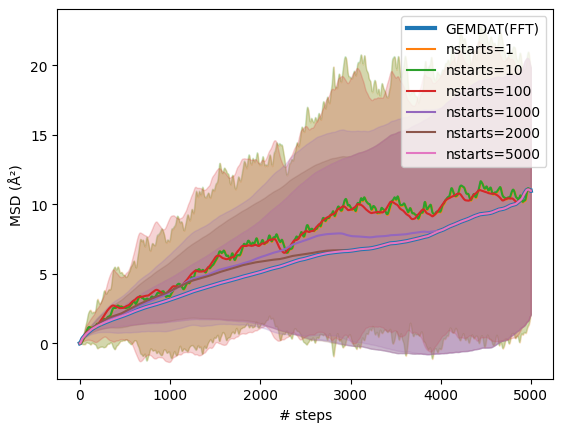

In [8]:
# Plot the results
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(fft_msd, lw=3, label='GEMDAT(FFT)')
last_color = ax.lines[-1].get_color()
ax.fill_between(range(fft_msd.shape[0]), fft_msd - fft_msd_std, fft_msd + fft_msd_std, color=last_color, alpha=0.2)
for nstarts, msd, msd_std in zip(nstarts_values, msd_results, msd_stds):
    ax.plot(msd, label=f'nstarts={nstarts}')
    last_color = ax.lines[-1].get_color()
    ax.fill_between(range(msd.shape[0]), msd- msd_std, msd + msd_std, color=last_color, alpha=0.2)
ax.set_xlabel('# steps')
ax.set_ylabel('MSD (Å²)')
ax.legend()
plt.show()

And we can also compare the time required by the different methods:

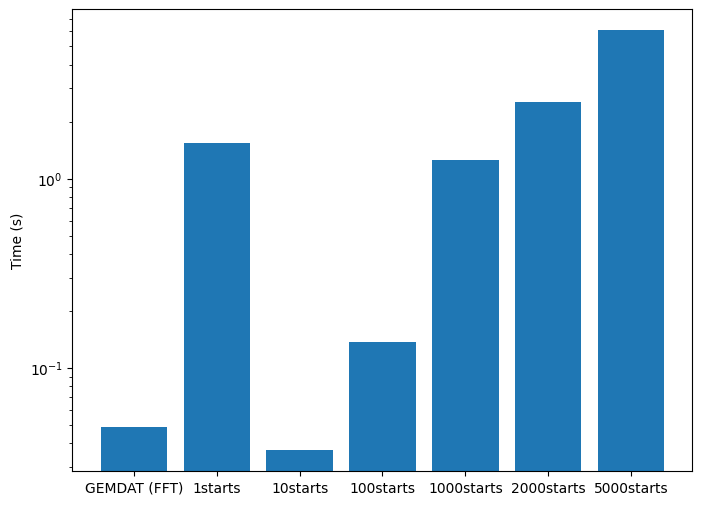

In [9]:
# Then we can compare the time
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(nstart_names, [time_fft, *time_results])
ax.set_ylabel('Time (s)')
ax.set_yscale('log')
plt.show()

It is clear that the FFT method implemented in GEMDAT is **precise** and **efficient**.

## MSD figures

Gemdat also provides automatic ways to create figures and plot the MSD. At the moment we support a `matplotlib` and a `plotly` version of this figure. They are straightforward to obtain:

/tmp/ipykernel_385369/3359742017.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()


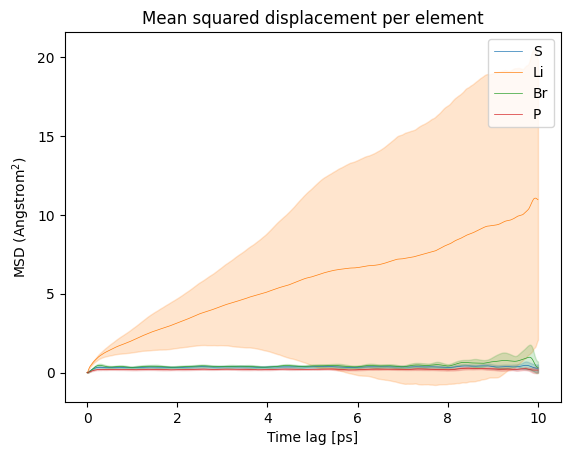

In [10]:
import gemdat.plots.matplotlib as mplt
fig1= mplt.msd_per_element(trajectory=trajectory)
fig1.show()

In [11]:
import gemdat.plots.plotly as pplt
fig2= pplt.msd_per_element(trajectory=trajectory)
fig2.show()

# Mean squared angular displacement

The MSAD measures the rotational decorrelation of the unit vectors that identify the direction of atomic bonds. 

It can be measured in a **direct** way 
$$ MSAD(t) = \frac{1}{N_b}\frac{1}{\langle \vec{r}(0)\rangle}\sum_i  \vec{r}_i(t)\vec{r}_i(0) $$
as the normalized autocorrelation of the bond orientation vectors $\vec{r}_i$. 
Similarly to the MSD the optimal way to measure it is via a **window** method that considers all the time intervals of size $t$.   

In GEMDAT we implement the **window** method to measure the MSAD using FFT, in a similar way as the MSD.
In this notebook we will show that GEMDAT method is much faster than a direct calculation.


First we import the trajectory and we compute the angular information as explained in the [rotations notebook](https://github.com/GEMDAT-repos/gemdat-notebooks/blob/main/rotations.ipynb)

In [12]:
from gemdat import Orientations
from gemdat.rotations import mean_squared_angular_displacement 
from gemdat.utils import VASPCACHE_ROTATIONS, cartesian_to_spherical

trajectory = Trajectory.from_cache(VASPCACHE_ROTATIONS)
central_atoms = 'S'
satellite_atoms = 'O'
n_expected_neigh = 8
normalize_trajectories = False
rotational_traj = Orientations(trajectory, central_atoms, satellite_atoms, n_expected_neigh, normalize_trajectories )
rotational_traj.set_symmetry_operations(sym_group='m-3m')

normalized_direct_cart = rotational_traj.get_unit_vectors_trajectory()

Now we can compute the MSAD using the default GEMDAT (FFT) method

In [13]:
time_0 = time.time()
fft_msad = mean_squared_angular_displacement(normalized_direct_cart)
fft_msad_std = fft_msad.std(axis=0)
fft_msad = fft_msad.mean(axis=0)
tgrid_fft = np.arange(fft_msad.shape[0])
time_fft = time.time()-time_0
print('The time for GEMDAT-FFT msad is', time_fft)

The time for GEMDAT-FFT msad is 0.0768885612487793


We compare GEMDAT performances with a direct calculation of the MSAD.
To make this direct calculation at least comparable with the efficient method implemented in GEMDAT, we compute the MSAD only on a limited (logspaced) number of `n-tgrid` values of time windows, and we parallelize the algorithm using  [numba](https://numba.pydata.org/).

In [14]:
@njit(parallel=True)
def _direct_msad(trajectory: np.ndarray,
                 n_tgrid: int) -> tuple[np.ndarray, np.ndarray]:
    """Compute the mean squared angular displacement using the direct
    method."""
    n_times, n_particles, n_coordinates = trajectory.shape

    # Measure the MSAD only on a logspaced t grid
    tgrid = np.empty(n_tgrid - 1, dtype=np.int32)
    for i in range(n_tgrid - 1):
        tgrid[i] = int(round(10**((i / (n_tgrid - 2)) *
                                  np.log10(n_times - 1))))

    tgrid = np.unique(tgrid)
    msad = np.full((len(tgrid), n_particles), np.nan)
    for k, dt in enumerate(tgrid):
        autocorr = np.sum(trajectory[:-dt] * trajectory[dt:],
                          axis=-1).astype(np.float32)
        msad[k, :] = np.mean(autocorr)

    return msad, tgrid

Now we compute the msad using the direct method to compare it with GEMDAT 

In [15]:
nts_values = [10, 100, 6665]
nts_names = [str(x)+'points' for x in nts_values]
nts_names.insert(0, 'GEMDAT(FFT)')
msad_results = []
msad_stds = []
tgrids = []
time_results = []

for nts in nts_values:
    time_0 = time.time()
    nts_msad, tgrid = _direct_msad(normalized_direct_cart,n_tgrid=nts)
    nts_msad = nts_msad/nts_msad[np.newaxis,0,:]
    nts_msad_std = nts_msad.std(axis=1)
    nts_msad = nts_msad.mean(axis=1)
    time_nstarts = time.time() - time_0
    print(f'The time for nts={nts} is', time_nstarts)
    msad_results.append(nts_msad)
    time_results.append(time_nstarts)
    msad_stds.append(nts_msad_std)
    tgrids.append(tgrid)

The time for nts=10 is 2.923266887664795
The time for nts=100 is 2.889331817626953
The time for nts=6665 is 30.470783710479736


And we plot the results

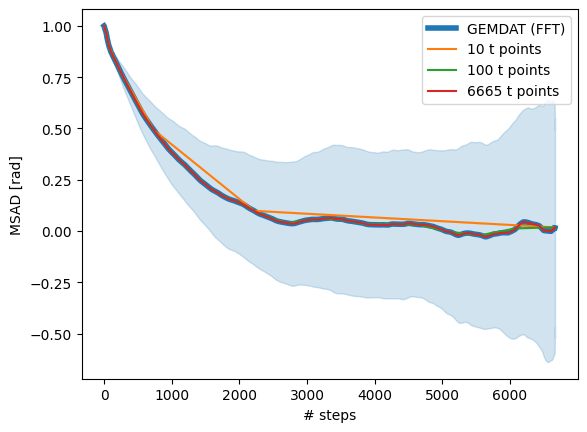

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(tgrid_fft, fft_msad, lw=4, label='GEMDAT (FFT)')
last_color = ax.lines[-1].get_color()
ax.fill_between(tgrid_fft, fft_msad - fft_msad_std, fft_msad + fft_msad_std, color=last_color, alpha=0.2)
for nts, msad, msad_std, tgrid in zip(nts_values, msad_results, msad_stds, tgrids):
    ax.plot(tgrid, msad, label=f'{nts} t points')
    last_color = ax.lines[-1].get_color()
    ax.fill_between(tgrid, msad- msad_std, msad + msad_std, color=last_color, alpha=0.2)
ax.set_xlabel('# steps')
ax.set_ylabel('MSAD [rad]')
ax.legend()
plt.show()

And compare the time required

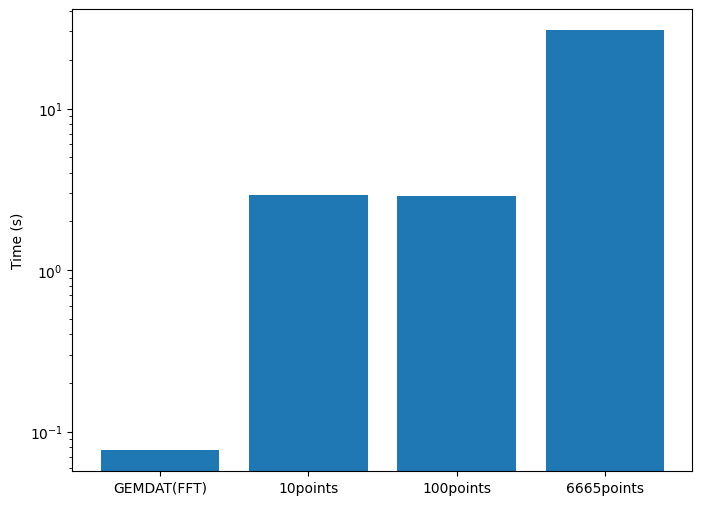

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(nts_names, [time_fft, *time_results])
ax.set_ylabel('Time (s)')
ax.set_yscale('log')
plt.show()

As in the case of the MSD, the GEMDAT implementation using FFT is precise and fast.

## MSAD figure

GEMDAT provides a way to automatically produce the MSAD plot using `matplotlib`:

/tmp/ipykernel_385369/2852656520.py:2: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



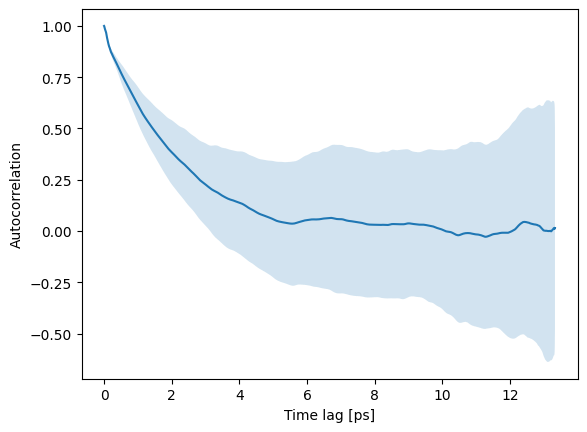

In [18]:
fig1 = mplt.unit_vector_autocorrelation(orientations=rotational_traj)
fig1.show()